# I will be implementing Logistic Regresion from scratch using the Stochastic Gradient Descent Algorithm.



## Dataset

We will use the following randomly generated data from sklearn.

* This dataset is randomly generated with 100 samples, 2 features and two classes {0,1}.

In [51]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification

In [52]:
# Generate a random n-class classification problem
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=1, 
                          n_classes=2, n_clusters_per_class=1)


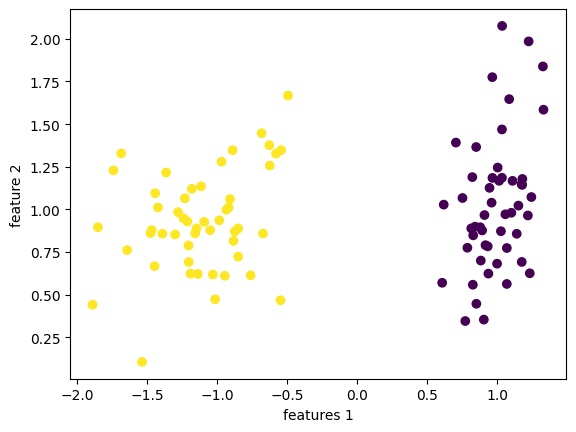

In [53]:
# Let us vizualize the data we have imported
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel('features 1')
plt.ylabel('feature 2')
plt.show()

## Train and Test Split Function

In [54]:
def train_test_split(X, y, train_size):

  '''
    this function takes as input the sample X, the corresponding targets y and the percentage of train_size in decimals
    and output the training and test set

    One can stack the X and y and shuffle the dataset, then split. Or one can shuffle the index of the rows and use it split.
    I will use the second option.
  '''

  num_of_rows = X.shape[0]          # or len(X),  getting the number of samples in the dataset.
  indexes = np.arange(num_of_rows)  # creating an array containing the indexes
  np.random.shuffle(indexes)        # shuffling the indexes array

  train_indexes = indexes[0 : round(num_of_rows*train_size)]    # getting the indexes of the train set, eg. first (100*0.8) rows
  test_indexes = indexes[round(num_of_rows*train_size) : ]      # getting the indexes of the test set, eg last 1 - (100*0.8) rows

  x_train, y_train = X[train_indexes], y[train_indexes] # extracting the training sets of X and Y respectively
  x_test, y_test  = X[test_indexes], y[test_indexes]   # extracting the testing sets of X and Y respectively

  return x_train, y_train, x_test, y_test

In [55]:
## extracting the training sets and testing sets of X and Y respectively

X_train, y_train, X_test, y_test = train_test_split(X,y,0.8)
print(f" The X training shape is: {X_train.shape} and the Y training shape is {y_train.shape}")
print(f" the test shape is", X_test.shape, f"and the Y test shape is", y_test.shape)

 The X training shape is: (80, 2) and the Y training shape is (80,)
 the test shape is (20, 2) and the Y test shape is (20,)


## Recaps

1. Logistic/sigmoid function:
\begin{equation}
σ(z)= \dfrac{1}{1+ e^{-z}}
\end{equation}
where  $z= x w$.
2. Derivative of Logistic/sigmoid function with respective to $z$:
\begin{equation}
σ'(z)= σ(z)(1-σ(z))
\end{equation}
3. Negative log likelihood or Cross-entropy loss:
\begin{equation}
l(w)= -\dfrac{1}{N}\sum_{i= 1}^{N} \left(y^{(i)}_{true} \times \log y^{(i)}_{pred} + (1-y^{(i)}_{true}) \times \log (1-y^{(i)}_{pred}) \right)
\end{equation}

where:

 $y_{pred}= σ(z)$, $z= xw$.

4. Derivative of Cross-entropy loss with respective to $w$:
\begin{equation}
dl(w)= -\dfrac{1}{N}x^T(y_{true} -y_{ped} )
\end{equation}
5. Apply Batch gradient descent to update $w$.

### We shall now create our Logistic Regression class 

In [79]:
class LogisticRegression:

  def __init__(self, epochs, learning_rate):
    self.w = None
    self.epochs = epochs
    self.learning_rate = learning_rate

  def add_ones(self, x):
    array_of_ones = np.ones((x.shape[0], 1))  # create an array with ones the size of the number of rows in the x dataset
    x_ones = np.hstack((array_of_ones, x))   # let us stack the array with ones with the x dataset
    return x_ones

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-(x @ self.w)))       # these will be the predictions, we use the sigmoid function to get the probalities of z = xw

  def cross_entropy_loss(self, y, y_pred):
    loss =  -(np.sum(y * np.log(y_pred)  +  (1 - y) * np.log(1 - y_pred)))  # computing the loss in point 3 of the recap above
    return loss

  def predict_probabilities(self, x):
    x = self.add_ones(x)             # we add a column of ones because the test set should have the same preprocessing as the train set
    y_pred = self.sigmoid(x)         # we use the sigmoid function to get the prediction probabilities
    return y_pred

  def predict(self, x):
    probabilities = self.predict_probabilities(x)        # we call the predict_probabilities method to get the prediction probalities
    output = [1 if p >= 0.5 else 0 for p in probabilities]      # now with a threshold of 0.5, we conclude that those >= 0.5 will belong to class 1 and those below 0.5 will belong to class 0
    return output

  ''' when using the stochastic gradient descent optimization algorithm, we need to shuffle the data at every epoch, so this method does that,
      we first stack the x_train and y_train together (we do this because if we only shuffle the x_train, we will lose its corresponding y value).
      Then we use numpy shuffle function and extract the x_train and the y_train back '''
  def shuffle(self, x, y): 
    # stack the x and y horizontally
    if x.ndim == 1:           # this is for the case where we have only one feature in the data, we need them to stand vertically, that's why we would reshape it, same for the y.
      x = x.reshape(-1, 1)
    if y.ndim == 1:
      y = y.reshape(-1,1)
    train_data = np.hstack((x,y))
    np.random.shuffle(train_data)
    return train_data[:, :-1], train_data[:, -1]

  
  def fit(self, x, y):
    x = self.add_ones(x)    # we add a column of ones to cater for the bias term in the parameters.

    self.w = np.zeros((x.shape[1], 1))    # we then initialize our weights (inclusive of the bias)

    epoch_loss = []              # we use this to gather the loss after every epoch
    for epoch in range(self.epochs):
      ## shuffle the data
      x_train, y_train = self.shuffle(x, y)

      sample_loss = 0
      for i in range(x_train.shape[0]):
        ## make predictions
        y_pred = self.sigmoid(x_train[i])

        ## compute loss
        loss = self.cross_entropy_loss(y_train[i], y_pred)

        ## compute gradient of loss
        gradient_of_loss = - (y_train[i] - y_pred) * x_train[i]

        ## update rule
        self.w = self.w - self.learning_rate * gradient_of_loss.reshape(-1,1)

        sample_loss += loss            # this becomes the total loss after every epoch     
      
      avg_loss = sample_loss / x.shape[0]     # we then get the average of this total loss and then this becomes the average loss at each epoch.
      epoch_loss.append(avg_loss)

      if epoch % 10 == 0:             # we want to see the losses, but not for every epoch, as they are many, so we want to see the loss at every 10th epoch
        print(f"Loss for epoch {epoch} is {avg_loss}")

  def accuracy(self, y, y_pred):      # this method helps us to see the accuracy on the test set
    acc = np.mean(y == y_pred)*100
    return acc


### We now test our built LogisticRegression class

In [80]:
# we instantiate an object of the class called model
model = LogisticRegression(100, 0.01)

# we now perform training on our train dataset
model.fit(X_train, y_train)

Loss for epoch 0 is 0.5984907808891105
Loss for epoch 10 is 0.13130789692149913
Loss for epoch 20 is 0.07412062771915683
Loss for epoch 30 is 0.052229693727263035
Loss for epoch 40 is 0.04058333905907777
Loss for epoch 50 is 0.0333175468464637
Loss for epoch 60 is 0.02833600112013159
Loss for epoch 70 is 0.024699329331004976
Loss for epoch 80 is 0.02192273046201842
Loss for epoch 90 is 0.01973012987963229


In [81]:
# let us see the predicted probabilities of the test set
model.predict_probabilities(X_test)

array([[0.03569495],
       [0.01466565],
       [0.97751044],
       [0.01651204],
       [0.9975753 ],
       [0.01229439],
       [0.01612883],
       [0.95039189],
       [0.0110363 ],
       [0.99401086],
       [0.99807421],
       [0.99417747],
       [0.99121024],
       [0.99271826],
       [0.02317008],
       [0.89442753],
       [0.9875464 ],
       [0.01092549],
       [0.96353318],
       [0.99332867]])

In [82]:
# and now, let us observe the class predictions
y_predictions = model.predict(X_test)
y_predictions

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]

In [83]:
# finally, let us see the accuracy we get
model.accuracy(y_test, y_predictions)

100.0

## Conclusion

* We have built a model to classify our new samples into either class 0 or class 1 and we obtained an accuracy of 100%.
* Note that this dataset is very small, one can increase the number of samples or the number of features, can add noise to the data and do other things to it. Or, one can even change the dataset and use a different one. 
* The main goal of this notebook is to show how to implement our own Logistic Regression algorithm using Stochastic Gradient Descent optimization algorithm.
* In the next sessions, I will do the same but use the Mini Batch Gradient Descent optimization algorithm.